# Budget vs Accuracy
In this notebook we compare the accuracy (root mean squared error, RMSE) the three multifidelity methods can achieve for a given computational budget. To this end, `2_samplesizes.py` computes the MFMC, MLMC, and MLBLUE samplesizes for different computational budgets. The MLBLUE optimization takes quite a while for that many different budgets, that's why the script should be run separately. Here, we are importing the results computed there.

## Imports

In [1]:
## Imports
import numpy as np
import pickle
import time
tStart_notebook = time.time()

import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches

## User settings

In [2]:
target_accuracy_95 = 1  # target accuracy for 95% confidence interval in mm SLR

## Load data

We are loading here the sample sizes that were computed for our paper [1].

In [3]:
filename = "results/samplesizes_t2050"
with open(filename, "rb") as file:
    [rescaling, 
     mean_costs, 
     sample_allocation_cost, 
     results, 
     samplesizes,
     chosen,
     cost_opt,
     errors,
     budgets,
     blue_sol_for_budget,
     covariances] = pickle.load(file)

The estimates of the errors has a missing entry at the very first iteration (where the budget was equal to exactly 1 high-fidelity solve) because this case caused an error in the `MLBLUE` software. We set it manually to the error for MC sampling with a single high-fidelity solve:

In [4]:
# set first entry in errors since this step caused an error in bluest
covar = covariances[-1]
errors[:, 0] = np.sqrt(covar[0,0] * 1 / np.floor(budgets[0]/mean_costs[0]))

In addition to the multifidelity estimators, we also want to see how standard MC sampling performs.

In [5]:
# chosen budget for MC
samples_mc = np.floor(budgets/mean_costs[0])
yolo = rescaling * np.sqrt(covar[0,0] * 1 / samples_mc)
err_mc = np.sqrt(covar[0,0] * 1 / samples_mc)
errors = np.vstack([errors, err_mc])

Rescale the error back to its original unit

In [6]:
# rescale everything to make code below simpler
errors = errors * rescaling
budgets = budgets / 24 # rescale to CPU-days

## Budget vs accuracy

In [7]:
## plot setup parameters

# colors
color_MC = "#333f48" # charcoal
color_MLMC = "#005f86" # UT darker blue
color_MFMC = "#bf5700" # burnt orange
color_MLBLUE = "#693668" # finn
method_colors = [color_MFMC, color_MLMC, color_MLBLUE, color_MC]

# labels
method_labels = ["MFMC", "MLMC", "MLBLUE", "MC"]
x_ticks = [2.7, 4.2, 31, 39, 382, 2*365]
x_ticks_label = ["2.7", "4.2", "31 ", " 39", "382", "730"]

# target accuracy
target_accuracy = 361.8 * target_accuracy_95 * 0.51
# convert from target accuracy (mm SLR) for the 95% confidence interval to the equivalent target accuracy of the
# RMSE in Gt

# chosen budget for MLMC, MFMC, MLBLUE, MC
indices_chosen = np.argmin(np.maximum(errors - target_accuracy, 0), axis = 1)
budget_chosen = budgets[indices_chosen]

# angle for annotations
alpha = -26.675

Now it's time for the plot

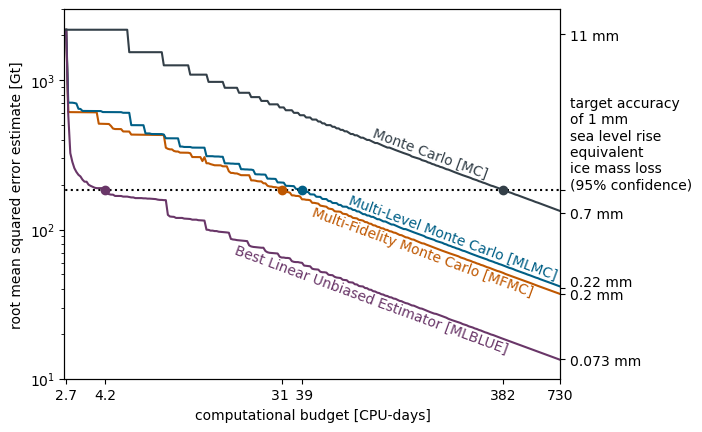

In [8]:
fig, ax = plt.subplots(1,1)

# plot budget vs accuracy
for i in range(4):
    ax.loglog(budgets, errors[i, :], 
              label = method_labels[i], color = method_colors[i])
    
#plot target accuracy
ax.plot([-1, 1000], target_accuracy*np.ones((2,)), linestyle = ":", label = "target accuracy", color = "k")

# mark where target accuracy is reached
for i in range(4):
    ax.plot([budgets[indices_chosen[i]]], [target_accuracy], 
            marker = "o", color = method_colors[i], linestyle = "")

rotation_adjustment = 6.5
# annotate lines
ax.annotate(text="Multi-Fidelity Monte Carlo [MFMC]", 
            xy=(budgets[120], 1.05*errors[0, -1]), 
            color=method_colors[0], 
            rotation = alpha+rotation_adjustment)

ax.annotate(text="Multi-Level Monte Carlo [MLMC]", 
            xy=(budgets[138], 1.22*errors[1, -1]), 
            color=method_colors[1], 
            rotation = alpha+rotation_adjustment)

ax.annotate(text="Best Linear Unbiased Estimator [MLBLUE]", 
            xy=(budgets[82], 1.2*errors[2, -1]), 
            color=method_colors[2], 
            rotation = alpha+rotation_adjustment)

ax.annotate(text="Monte Carlo [MC]", 
            xy=(budgets[150], 1.8*errors[3, -1]), 
            color=method_colors[3], 
            rotation = alpha+rotation_adjustment)

# ax.annotate(text="target accuracy", xy=(170, 368.1 *1.08), color = "k")


ax.set_xticks(x_ticks, x_ticks_label)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge
    top=False,         # ticks along the top edge
    labelbottom=True) # labels along the bottom edge
ticks = ax.get_xticklabels()

    
# annotate axes
ax.set_xlabel("computational budget [CPU-days]")
ax.set_ylabel("root mean squared error estimate [Gt]")
ax.set_title("")
#ax.set_ylim(10, 10*361.8)
ax.set_ylim(10, 3000)
ax.set_xlim(2.65, 730)

# y-axis on the right side
ax2 = ax.twinx()
ax2.set_yscale('log')

ax2.set_ylim((ax.get_ylim()[0]* 1.96 / 361.8, ax.get_ylim()[1]* 1.96 / 361.8))
ax2.set_yticks([0.073, 0.2, 0.22, 0.7, 1, 11], 
               ["0.073 mm", "0.2 mm", "0.22 mm\n", "0.7 mm", 
                "target accuracy\nof 1 mm \nsea level rise \nequivalent \nice mass loss\n(95% confidence)\n\n\n\n\n\n", 
                "11 mm"])

# ticks = ax2.get_yticklabels()
# ticks[1].set_verticalalignment("top")
# ticks[2].set_verticalalignment("bottom")

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge
    right=False,         # ticks along the top edge
    labelbottom=True) # labels along the bottom edge

# Chosen models and their sample sizes

In [9]:
mfmc_data = results[0, indices_chosen[0]]
mlmc_data = results[1, indices_chosen[1]]
mlblue_data = results[2, indices_chosen[2]]

get model indices and sample sizes for MFMC and MLMC

In [10]:
model_indices = np.zeros(3, dtype = object)
model_indices[0] = np.array(mfmc_data['models'])
model_indices[1] = np.array(mlmc_data['models'])

sample_sizes = np.zeros(3, dtype = object)
sample_sizes[0] = mfmc_data['samples']
sample_sizes[1] = mlmc_data['samples']

For MLBLUE, the results are saved in a different format, so we need to iterate a bit:

In [11]:
mlblue_models = []
mlblue_samples = np.zeros(13)

for i, subset in enumerate(mlblue_data['models']):
    for j, m in enumerate(subset):
        if not m in mlblue_models:
            mlblue_models.append(m)
        mlblue_samples[m] += mlblue_data['samples'][i]
        
model_indices[2] = np.array(mlblue_models)
sample_sizes[2] = np.array([mlblue_samples[m] for m in mlblue_models])

We want to know the accumulated cost for all the samples:

In [12]:
chosen_cost = np.zeros(3, dtype = object)

for i in range(3):
    yolo = np.zeros(model_indices[i].shape[0])
    for j, m in enumerate(model_indices[i]):
        yolo[j] = mean_costs[m] * sample_sizes[i][j]
        
    chosen_cost[i] = yolo

In [13]:
## plotting setup

myhatches = ["//"]*13
myhatches[0] = "xxx"
myhatches[1] = "xxx"
myhatches[2] = "xx"
myhatches[3] = "xx"
myhatches[4] = "x"
myhatches[5] = "x"
myhatches[6] = "xxx"
myhatches[7] = "xxx"
myhatches[8] = "xx"
myhatches[9] = "xx"
myhatches[10] = "x"
myhatches[11] = "x"
myhatches[12] = ""

my_names = ["high-fidelity (HO, fine)", "extrapolation (HO, fine)", 
            "HO, medium", "extrapolation (HO, medium)", 
            "HO, coarse", "extrapolation (HO, coarse)", 
            "SSA, fine", "extrapolation (SSA, fine)", 
            "SSA, medium", "extrapolation (SSA, medium)", 
            "SSA, coarse", "extrapolation (SSA, coarse)", 
            "interpolation (SSA, coarse)"]

cmap = mpl.colormaps['tab20c']

color_HO = cmap(1)
color_HOex = cmap(3)
color_SSA = cmap(17)
color_SSAex = cmap(19)
color_inter = cmap(10)

my_colors = [color_HO, color_HOex, color_HO, color_HOex, color_HO, color_HOex, 
                 color_SSA, color_SSAex, color_SSA, color_SSAex, color_SSA, color_SSAex, 
                 color_inter]

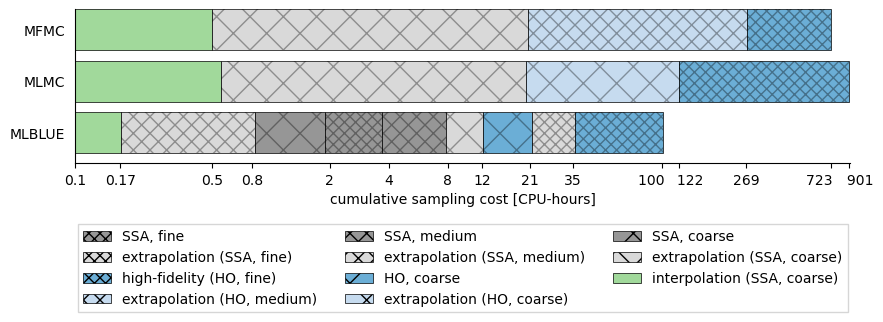

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (10, 2))

markers = np.zeros(3, dtype = object)
in_legend = []

for i in range(3):
    
    stop = 0
    markers[i] = []
    order = np.argsort(chosen_cost[i])
    
    for j in range(model_indices[i].shape[0]):
        rect = patches.Rectangle((stop, 2.2-i), chosen_cost[i][order[j]], 0.8, 
                                 linewidth=0.5, edgecolor='k', facecolor=my_colors[model_indices[i][order[j]]])
        
        rect_hatch = patches.Rectangle((stop, 2.2-i), chosen_cost[i][order[j]], 0.8, 
                                 linewidth=0, hatch=myhatches[model_indices[i][order[j]]], fill=False, alpha = 0.35)
        
        ax.add_patch(rect)
        ax.add_patch(rect_hatch)
        stop += chosen_cost[i][order[j]]
        markers[i].append(stop)
        
ax.set_ylim(0.0, 3)
ax.set_xlim(0.1, 910) #1.02*np.sum(chosen_cost[1])
ax.set_xscale("log", base=2)
ax.set_xlabel("cumulative sampling cost [CPU-hours]")

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

x_markers = [0.1, 0.17, 0.5, 0.8, 2, 4, 8, 12, 21, 35, 100, 122, 269, 723, 901]
x_marker_labels = [0.1, 0.17, 0.5, 0.8, 2, 4, 8, 12, 21, 35, "100     ", "     122", 269, "723     ", "     901"]
ax.set_xticks(x_markers, x_marker_labels)

ax.set_yticks([0.6, 1.6, 2.6], ["MLBLUE", "MLMC", "MFMC"], rotation = 0)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge
    right=False,         # ticks along the top edge
    labelbottom=True) # labels along the bottom edge

order = [6, 7, 0, 3, 8, 9, 4, 5, 10, 11, 12]
for i in order:
    rect_legend = patches.Rectangle((-2, -2), -1, -1, linewidth=0.5, edgecolor='k', 
                                    facecolor=my_colors[i], hatch=myhatches[i], 
                                    label = my_names[i])
    ax.add_patch(rect_legend)

ax.legend(loc='upper center', 
          bbox_to_anchor=(0.5, -0.35),
          fancybox=False, 
          shadow=False, 
          ncol=3)

## Saving
Save the selected sample sizes, model groups, etc.

In [18]:
filename = "results/chosen_MF_setup".format()
with open(filename, "wb") as output_file:
    pickle.dump([mfmc_data, 
                 mlmc_data, 
                 mlblue_data,
                 samples_mc], output_file)

## The End.

In [16]:
print("Runtime of this notebook: {} min".format((time.time()-tStart_notebook)/60))

Runtime of this notebook: 0.033131611347198484 min
